In [1]:
import numpy as np # linear algebra
import pandas as pd 
column_names = ['male', 'age', 'debt', 'married', 'bankcustomer', 'educationlevel', 'ethnicity', 'yearsemployed',
               'priordefault', 'employed', 'creditscore', 'driverslicense', 'citizen', 'zip', 'income', 'approved']

data = pd.read_csv('./data/credit.csv', header=None,  names=column_names)
data.reset_index(drop=True, inplace=True) 


data = data.dropna(how = 'all')
data = data[data.age != '?']

print(data.head())

from sklearn import preprocessing
for feat in ['male', 'married','bankcustomer', 'educationlevel', 'ethnicity','priordefault', 'employed', 'driverslicense', 'citizen', 'zip', 'approved']:
    data[feat] = preprocessing.LabelEncoder().fit_transform(data[feat])


#####################################################
#### For this experiment, we uniquely drop the default variable (prior default)
###################################################
#data = data.drop(['educationlevel'], axis=1)
    
print(len(data))

from pycausal.pycausal import pycausal as pc
pc = pc()
pc.start_vm()

from pycausal import prior as p
prior = p.knowledge(addtemporal = [['male', 'age','ethnicity'],[ 'debt', 'married', 'bankcustomer', 'educationlevel', 'yearsemployed',
                'employed', 'creditscore', 'driverslicense', 'citizen', 'zip', 'income'],['approved']])


from pycausal import search as s
tetrad = s.tetradrunner()
tetrad.run(algoId = 'fges', scoreId = 'cg-bic-score', dfs = data, priorKnowledge = prior,
           maxDegree = -1, faithfulnessAssumed = True, verbose = False)
tetrad.getEdges()

  male    age   debt married bankcustomer educationlevel ethnicity  \
0    b  30.83  0.000       u            g              w         v   
1    a  58.67  4.460       u            g              q         h   
2    a  24.50  0.500       u            g              q         h   
3    b  27.83  1.540       u            g              w         v   
4    b  20.17  5.625       u            g              w         v   

   yearsemployed priordefault employed  creditscore driverslicense citizen  \
0           1.25            t        t            1              f       g   
1           3.04            t        t            6              f       g   
2           1.50            t        f            0              f       g   
3           3.75            t        t            5              t       g   
4           1.71            t        f            0              f       s   

     zip  income approved  
0  00202       0        +  
1  00043     560        +  
2  00280     824        + 

['age --> yearsemployed',
 'priordefault --> age',
 'creditscore --> debt',
 'ethnicity --> age',
 'yearsemployed --> creditscore',
 'zip --> debt',
 'married --> approved',
 'yearsemployed --> debt',
 'employed --> creditscore',
 'bankcustomer --> approved',
 'employed --> approved',
 'priordefault --> yearsemployed',
 'bankcustomer --> employed',
 'bankcustomer --- married',
 'priordefault --> approved',
 'yearsemployed --> driverslicense',
 'citizen --> employed',
 'creditscore --> zip',
 'employed --> priordefault']

In [2]:
edges = []
for edge in tetrad.getEdges():
    edges.append(list([column_names.index(edge.split(' ')[0]), column_names.index(edge.split(' ')[-1])]))
print(edges )

[[1, 7], [8, 1], [10, 2], [6, 1], [7, 10], [13, 2], [3, 15], [7, 2], [9, 10], [4, 15], [9, 15], [8, 7], [4, 9], [4, 3], [8, 15], [7, 11], [12, 9], [10, 13], [9, 8]]


In [3]:
# Copy the above edge list 
column_names.index('male')

0

In [4]:
data.head()

,male,age,debt,married,bankcustomer,educationlevel,ethnicity,yearsemployed,priordefault,employed,creditscore,driverslicense,citizen,zip,income,approved
0,2,30.83,0.000,2,1,13,8,1.25,1,1,1,0,0,68,0,0
1,1,58.67,4.460,2,1,11,4,3.04,1,1,6,0,0,11,560,0
2,1,24.50,0.500,2,1,11,4,1.50,1,0,0,0,0,96,824,0
3,2,27.83,1.540,2,1,13,8,3.75,1,1,5,1,0,31,3,0
4,2,20.17,5.625,2,1,13,8,1.71,1,0,0,0,2,37,0,0


In [7]:
import numpy as np # linear algebra
import pandas as pd 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
#from models.DECAF_credit import *
from sklearn.metrics import confusion_matrix
            
column_names = ['male', 'age', 'debt', 'married', 'bankcustomer', 'educationlevel', 'ethnicity', 'yearsemployed',
               'priordefault', 'employed', 'creditscore', 'driverslicense', 'citizen', 'zip', 'income', 'approved']
data = pd.read_csv('./data/credit.csv', header=None,  names=column_names)
print(data.head(5))
data.reset_index(drop=True, inplace=True) 
print(len(data))

data = data.dropna(how = 'all')

data = data[data.age != '?']
data.reset_index(drop=True, inplace = True)

print(len(data))

from sklearn import preprocessing
for feat in ['male', 'married','bankcustomer', 'educationlevel', 'ethnicity','priordefault', 'employed', 'driverslicense', 'citizen', 'zip', 'approved']:
    data[feat] = preprocessing.LabelEncoder().fit_transform(data[feat])

data['age'] = pd.to_numeric(data['age'],errors='coerce')

#####################################################
#### For this experiment, we uniquely drop the default variable (prior default)
###################################################
#data = data.drop(['priordefault'], axis=1)

# binarize the protected variable
data.loc[data['ethnicity'] <= 4, 'ethnicity'] = 0
data.loc[data['ethnicity'] > 4, 'ethnicity']= 1
data.loc[data['ethnicity'] ==1 , 'employed'] =  1

biased_data = data.copy()
biased_data.loc[biased_data['ethnicity'] == 1, 'approved'] = 0


thresh = 0.8

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(data)
data[data.columns] = scaler.fit_transform(data)
biased_data[biased_data.columns] = scaler.transform(biased_data)
print(biased_data.approved.value_counts(), biased_data.ethnicity.value_counts())

  male    age   debt married bankcustomer educationlevel ethnicity  \
0    b  30.83  0.000       u            g              w         v   
1    a  58.67  4.460       u            g              q         h   
2    a  24.50  0.500       u            g              q         h   
3    b  27.83  1.540       u            g              w         v   
4    b  20.17  5.625       u            g              w         v   

   yearsemployed priordefault employed  creditscore driverslicense citizen  \
0           1.25            t        t            1              f       g   
1           3.04            t        t            6              f       g   
2           1.50            t        f            0              f       g   
3           3.75            t        t            5              t       g   
4           1.71            t        f            0              f       s   

     zip  income approved  
0  00202       0        +  
1  00043     560        +  
2  00280     824        + 

In [33]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
from models.fairGAN import Medgan
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pickle
def train_fairgan(datapath):

    #data = np.load(datapath, allow_pickle = True)
    inputDim = data.shape[1]-1
    inputNum = data.shape[0]
    tf.reset_default_graph()
    mg = Medgan(dataType='count',
                inputDim=inputDim,
                embeddingDim=128,
                randomDim=128,
                generatorDims=(128,128),
                discriminatorDims=(256,128),
                compressDims=(),
                decompressDims=(),
                bnDecay=0.99,
                l2scale=0.001)

    model_file = ''
    out_file = 'fair'
    batch_size = 32
    
    mg.train(dataPath=datapath,
             modelPath=model_file,
             outPath=out_file,
             pretrainEpochs=200,
             nEpochs=400,
             discriminatorTrainPeriod=2,
             generatorTrainPeriod=1,
             pretrainBatchSize=batch_size,
             batchSize=batch_size,
             protected = [6],
             saveMaxKeep=0)
    tf.reset_default_graph()
    return mg.generateData(nSamples=inputNum,
                        modelFile='fair-399',
                        batchSize=batch_size,
                        outFile=out_file)

In [34]:
def train_model(data, bias_dict = {}, surrogate = False):
    dm = DataModule(data.values)
    data_tensor = dm.setup()

    #dm = SyntheticDataModule()
    #data_tensor = dm.setup()
    #activation_layer = nn.ReLU(inplace=True) #nn.LeakyReLU(0.2, inplace=True)

    # Causal GAN
    #%% Import functions

    params = dict()
    params["iterations"] = 2000
    params["h_dim"] = 200
    params["z_dim"] = 10
    params["mb_size"] = 128
    params["lambda_gp"] = 10
    params["d_updates"] = 10

    max_epochs = (10 + 1) * 25 
    number_of_gpus = 0


    # Remove all the education level edges.#5
    biased_list =[[1, 7],  [7, 10], 
                  [8, 10], 
                  [2, 13], [9, 5], [9, 10], 
                  [7, 8], 
                  [12, 3], # Removed edge between age and ethnicity.
                  [9, 4], 
                  [8, 3], 
                  [6, 15], # Remove this for training purposes. 
                  [7, 11], [7, 15], [13, 3], [13, 14], [10, 2], [2, 14], 
                  [5, 3], [7, 2], [9, 15], [8, 2], [14, 3], [14, 15], [4, 3], [8, 15], 
                  [13, 11], [9, 12], [8, 9],
                 [6,9] # This is the edge from ethnicity to employed
                 ]
    
    
    biased_list =[[1, 7],  [7, 10], 
                  [8, 10], 
                  [2, 13],  [9, 10], 
                  [7, 8], 
                  [12, 3], # Removed edge between age and ethnicity.
                  [9, 4], 
                  [8, 3], 
                  [6, 15], # Remove this for training purposes. 
                  [7, 11], [7, 15], [13, 3], [13, 14], [10, 2], [2, 14], [7, 2], [9, 15], [8, 2], [14, 3], [14, 15], [4, 3], [8, 15], 
                  [13, 11], [9, 12], [8, 9],
                 [6,9] # This is the edge from ethnicity to employed
                 ]
    
    
    # model initialisation and train
    model = causal_gan(dm, dag_seed = biased_list,
               h_dim=200,
               lr=1e-3,
               batch_size=64,
               lambda_privacy=0,
               lambda_gp=10,
               d_updates=10,
               causal=True,
               alpha=2,
               rho=2,
               weight_decay=1e-2,
               grad_dag_loss=False,
               l1_g=0,
               l1_W=1e-4,
               p_gen=-0.2,
               use_mask=True,
              )
    print(model.hparams)
    trainer = pl.Trainer(gpus=number_of_gpus, max_epochs=max_epochs, progress_bar_refresh_rate=1, profiler = False)
    model.set_val_data(data_tensor)

    print("Training")
    trainer.fit(model, dm)
    synth_data = model.gen_synthetic(data_tensor, gen_order = model.get_gen_order(), biased_edges = bias_dict, surrogate = surrogate).detach().numpy()
    print(synth_data.shape)
    
    return synth_data



In [10]:
protected_idx = 6
# ADSGAN
#%% Import functions
from models.adsgan import adsgan
from models.gan import gan
from models.pategan import pategan
from models.vae import vae
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
            
params = dict()
params["iterations"] = 2000
params["h_dim"] = 200
params["z_dim"] = 10
params["mb_size"] = 128
params["lambda_gp"] = 10
params["d_updates"] = 10
params['lambda'] = 0
def view_stats_new(method_list, input_data, orig_data = [], protected = '', skip_synth = False, protected_idx = -1, runs =3, bias_dict = {}, remove_protected = False, surrogate = False):

    summary = ''
    
    samples = 5000
    # Note that for gender 0 is female, and 1 is male
    

    
    if not remove_protected:
        x_pos = orig_data[orig_data[p_attr] == 0].drop(['approved'], axis = 1)[:samples]
        y_pos = orig_data[orig_data[p_attr] == 0]['approved'][:samples]
        x_neg = orig_data[orig_data[p_attr] == 1].drop(['approved'], axis = 1)[:samples]
        y_neg = orig_data[orig_data[p_attr] == 1]['approved'][:samples]
        print(len(x_pos), len(y_pos), len(x_neg), len(y_neg))
    else:
        input_data = input_data.drop([protected], axis = 1)
        x_pos = orig_data[orig_data[p_attr] == 0].drop(['approved', protected], axis = 1)[:samples]
        y_pos = orig_data[orig_data[p_attr] == 0]['approved'][:samples]
        x_neg = orig_data[orig_data[p_attr] == 1].drop(['approved', protected], axis = 1)[:samples]
        y_neg = orig_data[orig_data[p_attr] == 1]['approved'][:samples]
        print(len(x_pos), len(y_pos), len(x_neg), len(y_neg))
        
    X_unbiased = pd.concat([x_pos, x_neg],axis=0).copy()
    y_unbiased  = pd.concat([y_pos, y_neg],axis=0).copy()
    
    for method in method_list:
        
        params['gen_model_name'] = method.replace('-pr', '')
        
        if method == 'adsgan':
            params['lambda'] = 0
        else:
            params['lambda'] = 1
            
            
        if method == 'vae':
            params["iterations"] = 1000
        else:
            params["iterations"] = 2000
        err = []
        feat_importance = []
        recall_ratio = []
        
        mutual_info = []
        precision = []
        recall = []
        density =[]
        coverage = []
        roc =[]
        
        
        
        for i in range(runs):
            
            if skip_synth:
                synth_data = input_data.values
            else:
                if method == 'fairgan':
                    # Need to swap 0 column with protected idx.
                    temp = input_data.copy()
                    popped = temp.pop('ethnicity')
                    temp.insert(0, 'ethnicity', popped)
                    
                    
                    pickle.dump(temp.values, open( "adult.npy", "wb" ) )
                    synth_data, synth_data_z = train_fairgan('adult.npy')
                    # Have to swap columns back like so.... x[:,[2,1]] = x[:,[1,2]]
                    #synth_data[:,[0,6]] = synth_data[:,[6,0]]
                    print("synth before:", synth_data.shape, synth_data_z.shape)
                    synth_data = np.insert(synth_data, 6, synth_data_z, axis=1)
                    print("synth after:", synth_data.shape)

                elif method == 'adsgan' or method == 'adsgan-pr':
                    synth_data = adsgan(input_data, params)
                elif method == 'gan' or method == 'wgan' or method == 'gan-pr' or method == 'wgan-pr':
                    synth_data = gan(input_data, params)
                elif method == 'vae':
                    synth_data = vae(input_data, params)
                else:
                    synth_data = train_model(input_data, bias_dict, surrogate = surrogate)
            
            

                                                     
            # This step is to ensure at least one sample there.
            pos_sample = input_data[input_data.approved == 0].iloc[0].values
            neg_sample = input_data[input_data.approved == 1].iloc[0].values
            synth_data = np.concatenate([synth_data, [pos_sample], [neg_sample]], axis = 0)        
            X = synth_data[:,:-1]

            #if remove_protected: 
            #    X = np.delete(synth_data, protected_idx, axis = 1)[:,:-1]
            y = np.round(synth_data[:, -1])

            mlp = MLPClassifier(random_state = i, max_iter = 100).fit(X, y)
            #mlp = LogisticRegression(random_state = i, max_iter = 100).fit(X, y)
                
            for X_unbiased, y_unbiased, _label in zip([x_pos, x_neg, pd.concat([x_pos, x_neg],axis=0).copy()], 
                                                      [y_pos, y_neg, pd.concat([y_pos, y_neg],axis=0).copy()],
                                                      ['pos', 'neg', 'both']):
                print("LOGGGING", len(X_unbiased), len(y_unbiased))
                if not remove_protected:
                    def compute_FTU(x):
                        x[p_attr] = 0
                        neg = mlp.predict(x)
                        x[p_attr] = 1
                        pos = mlp.predict(x)
                        return pos-neg
                    if _label == 'pos':
                        FTU = compute_FTU(x_pos)
                    elif _label == 'neg':
                        FTU = compute_FTU(x_neg)
                    else:
                        x_all = pd.concat([x_pos, x_neg],axis=0)
                        FTU = compute_FTU(x_all) 
                else:
                    FTU = 0 # by definition
                #print('FTU', FTU)
                pred_pos = mlp.predict(x_pos)
                pred_neg = mlp.predict(x_neg)
                if _label == 'pos':
                    DP = np.mean(pred_pos)
                elif _label =='neg':
                    DP = np.mean(pred_neg)
                else:
                    DP = np.mean(pred_pos)-np.mean(pred_neg)
                #print('DP', DP)

                CM = confusion_matrix(y_pos, mlp.predict(x_pos))
                TN = CM[0][0]
                FN = CM[1][0]
                TP = CM[1][1]
                FP = CM[0][1]

                tpr_pos = CM[1][1]/(CM[0][0]+CM[0][1])
                CM = confusion_matrix(y_neg, mlp.predict(x_neg))
                tpr_neg = CM[1][1]/(CM[1][1]+CM[0][1])

                roc.append(roc_auc_score(y_unbiased, mlp.predict_proba(X_unbiased)[:,1]))

                print(tpr_pos), print(tpr_neg)
                err.append(DP)#tpr_pos - tpr_neg)
                if True:
                    feat_importance.append(np.mean(FTU)) # BB 06/05 - just checking whether this leads to decent results.
                elif protected_idx >= 0:
                    feat_importance.append(mlp.coef_[0][protected_idx])

                else:
                    feat_importance.append(-1)

                print("Feature Importance = ", feat_importance)

                mutual_info.append(-1)


                if remove_protected:
                    results = compute_metrics(orig_data.drop([protected], axis = 1), synth_data,  which_metric = [['PRDC']], 
                                           wd_params = {},model = None,verbose = True)
                else:
                    #results = compute_metrics(orig_data.drop([protected], axis=1), np.delete(synth_data, protected_idx, 1),  which_metric = [['PRDC']], 
                    #                       wd_params = {},model = None,verbose = True)
                    

                    if _label == 'pos':
                        results = compute_metrics(pd.concat([X_unbiased, y_unbiased],axis=1), synth_data[synth_data[:,protected_idx].astype(bool)],  which_metric = [['PRDC']], 
                                           wd_params = {},model = None,verbose = True)
                    elif _label == 'neg':
                        print("Computing neg")
                        print( synth_data[1-synth_data[:,protected_idx].astype(bool)].shape)
                        results = compute_metrics(pd.concat([X_unbiased, y_unbiased],axis=1), synth_data[1-synth_data[:,protected_idx].astype(bool)],  which_metric = [['PRDC']], 
                                           wd_params = {},model = None,verbose = True)
                    else:
                        results = compute_metrics(pd.concat([X_unbiased, y_unbiased],axis=1), synth_data,  which_metric = [['PRDC']], 
                                           wd_params = {},model = None,verbose = True)
                precision.append(results['precision'])
                recall.append(results['recall'])
                density.append(results['density'])
                coverage.append(results['coverage'])

                # Writing to file
                with open("plots_surrogate_confounder_" + _label + '.csv', "a") as log:
                    # Writing data to a file
                    log.write(method +"," + str(bias) + "," + str(results['precision']) + ',' + str(results['recall']) + ',' + str(results['density']) + \
                              ',' + str(results['coverage']) + ',' + str(err[-1]) + ',' + str(feat_importance[-1]) + ',' + str(roc[-1]) + '\n')

        if skip_synth:
            print("no_synth", round(np.mean(err),3), round(np.std(err),3), 
              round(np.mean(feat_importance),3), round(np.std(feat_importance),3),
              round(np.mean(mutual_info),3), round(np.std(mutual_info),3)
             )
            break
        else:
            print(method, round(np.mean(err),3), round(np.std(err),3), 
              round(np.mean(feat_importance),3), round(np.std(feat_importance),3),
              round(np.mean(mutual_info),3), round(np.std(mutual_info),3)
             )

        #summary+= method + '&$' + str(round(np.mean(precision),3)) + '\pm' + str(round(np.std(precision),3)) + '$&$' + str(round(np.mean(recall),3)) + '\pm' + str(round(np.std(recall),3)) + \
        #         '$&$' + str(round(np.mean(density),3)) + '\pm' + str(round(np.std(density),3)) + '$&$' + str(round(np.mean(coverage),3)) + '\pm' + str(round(np.std(coverage),3)) + \
        #         '$&$' + str(round(np.mean(err),3)) + '\pm' + str(round(np.std(err),3)) + '$&$' + str(round(np.mean(mutual_info),3)) + '\pm' + str(round(np.std(mutual_info),3)) + '$\\\\\n'
        
        
        summary+= method + '&$' + str(round(np.mean(precision),3)) + '\pm' + str(round(np.std(precision),3)) + '$&$' + str(round(np.mean(recall),3)) + '\pm' + str(round(np.std(recall),3)) + \
                 '$&$' + str(round(np.mean(err),3)) + '\pm' + str(round(np.std(err),3)) + '$&$' + str(round(np.mean(feat_importance),3)) + '\pm' + str(round(np.std(feat_importance),3)) + \
                 '$&$' + str(round(np.mean(roc),3)) + '\pm' + str(round(np.std(roc),3)) +'$\\\\\n'
        print(summary)

ModuleNotFoundError: No module named 'models.adsgan'

In [9]:
import pickle 
p_idx = 6
p_attr = 'ethnicity'
for p in [0, 0.2, 0.4, 0.6, 0.8, 1]:
#for p in [0, 0.2, 0.4]:
    column_names = ['male', 'age', 'debt', 'married', 'bankcustomer', 'educationlevel', 'ethnicity', 'yearsemployed',
               'priordefault', 'employed', 'creditscore', 'driverslicense', 'citizen', 'zip', 'income', 'approved']
    data = pd.read_csv('./data/credit.csv', header=None,  names=column_names)
    data.reset_index(drop=True, inplace=True) 
    data = data.dropna(how = 'all')

    data = data[data.age != '?']
    data.reset_index(drop=True, inplace = True)


    from sklearn import preprocessing
    for feat in ['male', 'married','bankcustomer', 'educationlevel', 'ethnicity','priordefault', 'employed', 'driverslicense', 'citizen', 'zip', 'approved']:
        data[feat] = preprocessing.LabelEncoder().fit_transform(data[feat])

    data['age'] = pd.to_numeric(data['age'],errors='coerce')


    data.loc[data['ethnicity'] <= 4, 'ethnicity'] = 0
    data.loc[data['ethnicity'] > 4, 'ethnicity']= 1
    
    
    data.loc[data['ethnicity'] ==1 , 'employed'] =  1

    biased_data = data.copy()
    
    
    bias = p
    biased_data.loc[biased_data['ethnicity'] == 1, 'approved'] = 
                    np.logical_and(biased_data.loc[biased_data['ethnicity'] == 1, 'approved'].values, 
                   np.random.binomial(1, bias, len(biased_data.loc[biased_data['ethnicity'] == 1, 'approved']))).astype(int)
    print(biased_data['approved'].value_counts())


    thresh = 0.8

    from sklearn.preprocessing import MinMaxScaler

    scaler = MinMaxScaler()
    scaler.fit(data)
    data[data.columns] = scaler.fit_transform(data)
    biased_data[biased_data.columns] = scaler.transform(biased_data)
    
    import pickle 
    p_idx = 6
    p_attr = 'ethnicity'

    view_stats_new(['fairgan'], biased_data, protected = p_attr, remove_protected = False,
               orig_data = data ,protected_idx = p_idx, bias_dict ={})

    #view_stats_new(['gan', 'wgan', 'adsgan'], biased_data, protected = p_attr, remove_protected = False,
    #           orig_data = data ,protected_idx = p_idx, bias_dict ={})
    
    view_stats_new(['DECAF'], biased_data, protected = p_attr, remove_protected = False,
           orig_data = data ,protected_idx = p_idx, bias_dict ={})

    view_stats_new(['DECAF-FTU1'], biased_data, protected = p_attr, remove_protected = False,
               orig_data = data ,protected_idx = p_idx, bias_dict ={15:[6]})
    
    view_stats_new(['DECAF-FTU2'], biased_data, protected = p_attr, remove_protected = False,
               orig_data = data ,protected_idx = p_idx, bias_dict ={15:[6]}, surrogate = True,)

    view_stats_new(['DECAF-DP'], biased_data, protected = p_attr, remove_protected = False,
               orig_data = data ,protected_idx = p_idx, bias_dict ={15:[6,9]})

0    539
1    139
Name: approved, dtype: int64


NameError: name 'view_stats_new' is not defined

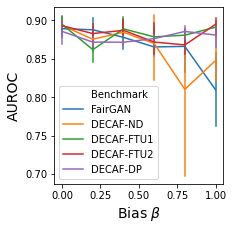

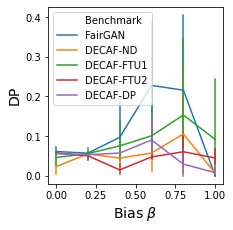

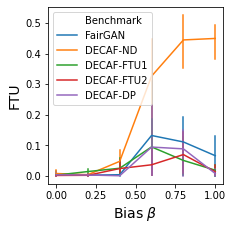

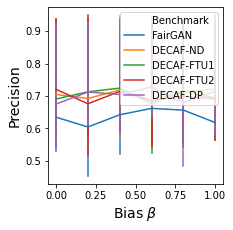

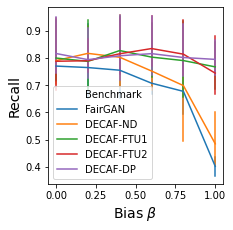

In [38]:
import os, glob
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
path = 'logs' # use your path
all_files = glob.glob(path + "/*.log")

li = []


methods = ['Benchmark', 'bias', 'precision', 'recall', 'density', 'coverage', 'dp', 'ftu', 'auc']




def read_df(filename):
    df = pd.read_csv(filename, index_col=False, header=0, names = methods)
    df['ftu'] = abs(df['ftu'])
    df['dp'] = abs(df['dp'])
    df.loc[df.Benchmark == 'fairgan', 'Benchmark'] = 'FairGAN'
    df.loc[df.Benchmark == 'DECAF', 'Benchmark'] = 'DECAF-ND'
    df = df[df.Benchmark != 'adsgan']
    
    df = df[df.Benchmark != 'adsgan-pr']
    df = df[df.Benchmark != 'gan']
    df = df[df.Benchmark != 'gan-pr']
    df = df[df.Benchmark != 'wgan']
    df = df[df.Benchmark != 'wgan-pr']
    df.bias = 1 - df.bias
    return df


def read_df2(filename):
    df = pd.read_csv(filename, index_col=False, header=0, names = methods)
    df['ftu'] = abs(df['ftu'])
    df['dp'] = df['dp'] - np.min(df['dp'])
    df.loc[df.Benchmark == 'fairgan', 'Benchmark'] = 'FairGAN'
    df.loc[df.Benchmark == 'DECAF', 'Benchmark'] = 'DECAF-ND'
    df = df[df.Benchmark != 'adsgan']
    
    df = df[df.Benchmark != 'adsgan-pr']
    df = df[df.Benchmark != 'gan']
    df = df[df.Benchmark != 'gan-pr']
    df = df[df.Benchmark != 'wgan']
    df = df[df.Benchmark != 'wgan-pr']
    df = df[df.Benchmark != 'FairGAN']

    return df


def read_df3(filename):
    df = pd.read_csv(filename, index_col=False, header=0, names = methods)
    df['ftu'] = abs(df['ftu'])
    df['dp'] = abs(df['dp'])
    df.loc[df.Benchmark == 'fairgan', 'Benchmark'] = 'FairGAN'
    df.loc[df.Benchmark == 'DECAF', 'Benchmark'] = 'DECAF-ND'
    df.loc[df.Benchmark == 'DECAF-FTU', 'Benchmark'] = 'DECAF-FTU1'
    df = df[df.Benchmark != 'adsgan']
    
    df = df[df.Benchmark != 'adsgan-pr']
    df = df[df.Benchmark != 'gan']
    df = df[df.Benchmark != 'gan-pr']
    df = df[df.Benchmark != 'wgan']
    df = df[df.Benchmark != 'wgan-pr']
    df = df[df.Benchmark != 'FairGAN']
    df.bias = 1 - df.bias
    return df

import seaborn as sns

df = read_df('plots_surrogate_confounder_both.csv')
dims = (3.3,3.3)
plt.figure(figsize = dims)

fig = sns.lineplot(data=df, x='bias', y = 'auc', hue = 'Benchmark', err_style = "bars")


plt.xlabel(r"Bias $\beta$", fontsize=14)
plt.ylabel("AUROC", fontsize=14)
plt.tight_layout()
plt.savefig('fig_auroc2.pdf')

plt.figure(figsize = dims)
sns.lineplot(data=df, x='bias', y = 'dp', hue = 'Benchmark',err_style="bars")
plt.xlabel(r"Bias $\beta$", fontsize=14)
plt.ylabel("DP", fontsize=14)
plt.tight_layout()
plt.savefig('fig_dp2.pdf')


plt.figure(figsize = dims)
sns.lineplot(data=df, x='bias', y = 'ftu', hue = 'Benchmark', err_style="bars")
plt.xlabel(r"Bias $\beta$", fontsize=14)
plt.ylabel("FTU", fontsize=14)
plt.tight_layout()
plt.savefig('fig_ftu2.pdf')

plt.figure(figsize = dims)
sns.lineplot(data=df, x='bias', y = 'precision', hue = 'Benchmark',err_style="bars")
plt.xlabel(r"Bias $\beta$", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.tight_layout()
plt.savefig('fig_prec2.pdf')


plt.figure(figsize = dims)
sns.lineplot(data=df, x='bias', y = 'recall', hue = 'Benchmark',err_style="bars" )
plt.xlabel(r"Bias $\beta$", fontsize=14)
plt.ylabel("Recall", fontsize=14)
plt.tight_layout()
plt.savefig('fig_recall2.pdf')